
# SEMI SUPERVISED LEARNING WITH DECISION TREE

In [1]:
import os
from PIL import Image, ImageFilter
import numpy as np 

#Dataset Directory 
alphabet_dir = "ASL_Dataset/Train"

images = []
labels = []

Pre-processing the Dataset

In [2]:
max_images_per_folder = 800
size = (256, 256)  
def horizontal_flip(image):
    flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)
    return flipped_image

# Noise removal: Gaussian blur
def remove_noise(image):
    pil_image = Image.fromarray(np.uint8(image*255))  
    denoised_image = pil_image.filter(ImageFilter.GaussianBlur(radius=2))
    denoised_array = np.array(denoised_image) / 255.0  
    return denoised_array

images = []
labels = []

for folder_name in os.listdir(alphabet_dir):
    folder_path = os.path.join(alphabet_dir, folder_name)

    image_counter = 0

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            if image_counter >= max_images_per_folder:
                break
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)

            image = image.resize(size)

            image = image.convert('L')

            image = np.array(image) / 255.0

            image = remove_noise(image)

            images.append(image)
            labels.append(folder_name)
            image_counter += 1

images = np.array(images)
labels = np.array(labels)

In [3]:
len(labels)

22400

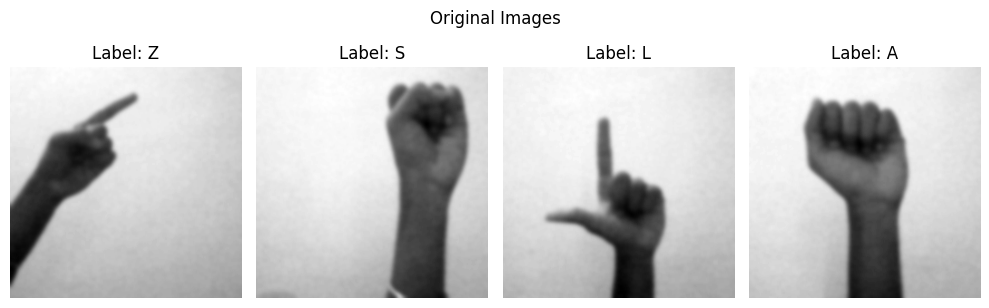

In [4]:
import matplotlib.pyplot as plt

random_indices = np.random.choice(len(labels), size=4, replace=False)

Original_images = images[random_indices]
Original_labels = labels[random_indices]

plt.figure(figsize=(10, 6))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(Original_images[i], cmap='gray')
    plt.title(f"Label: {Original_labels[i]}")
    plt.axis('off')
plt.suptitle('Original Images')
plt.tight_layout()
plt.show()

PCA

In [5]:
num_images = images.shape[0]
flattened_images = images.reshape(num_images, -1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_images = scaler.fit_transform(flattened_images)

from sklearn.decomposition import PCA

num_components = 25
pca = PCA(n_components=num_components)
reduced_images = pca.fit_transform(standardized_images)
reconstructed_images = pca.inverse_transform(reduced_images)


In [6]:
print(reconstructed_images.shape)
print(reduced_images.shape)

(22400, 65536)
(22400, 25)


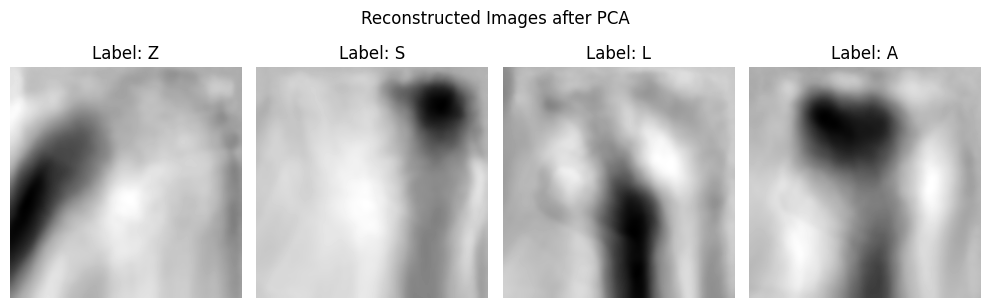

In [7]:
import numpy as np 

reconstructed_img = reconstructed_images[random_indices]
reconstructed_labels = labels[random_indices]

plt.figure(figsize=(10, 6))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(reconstructed_img[i].reshape(size), cmap='gray')
    plt.title(f"Label: {reconstructed_labels[i]}")
    plt.axis('off')
plt.suptitle('Reconstructed Images after PCA')
plt.tight_layout()
plt.show()

Outlier Detection

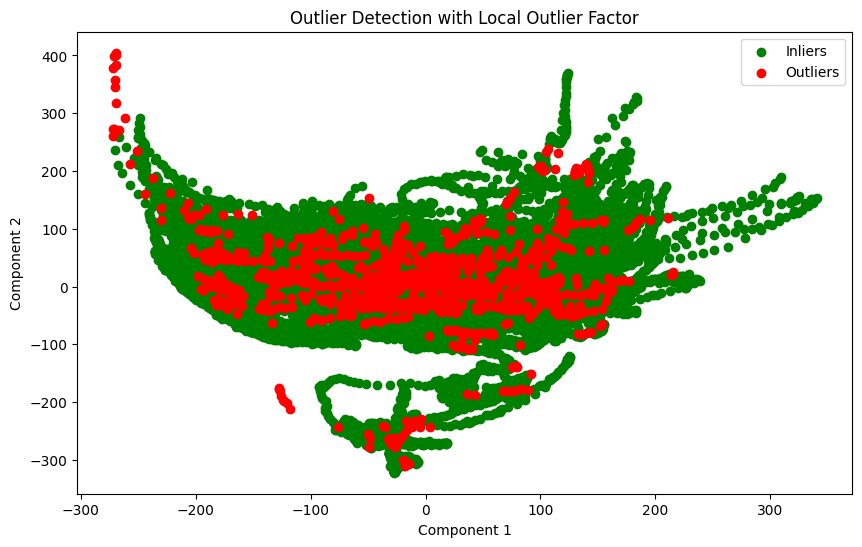

In [8]:
from sklearn.neighbors import LocalOutlierFactor
outlier_detector = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
outlier_labels = outlier_detector.fit_predict(reduced_images)

outliers = reduced_images[outlier_labels == -1]
inliers = reduced_images[outlier_labels == 1]

plt.figure(figsize=(10, 6))
plt.scatter(inliers[:, 0], inliers[:, 1], c='green', label='Inliers')
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', label='Outliers')
plt.title('Outlier Detection with Local Outlier Factor')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

In [9]:
import cupy as cp
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X = reduced_images
y = labels

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, test_size=0.8, stratify=y)

X_labeled = cp.asarray(X_labeled)
y_labeled = cp.asarray(y_labeled)
X_unlabeled = cp.asarray(X_unlabeled)
y_unlabeled = cp.asarray(y_unlabeled)

Class Distribution

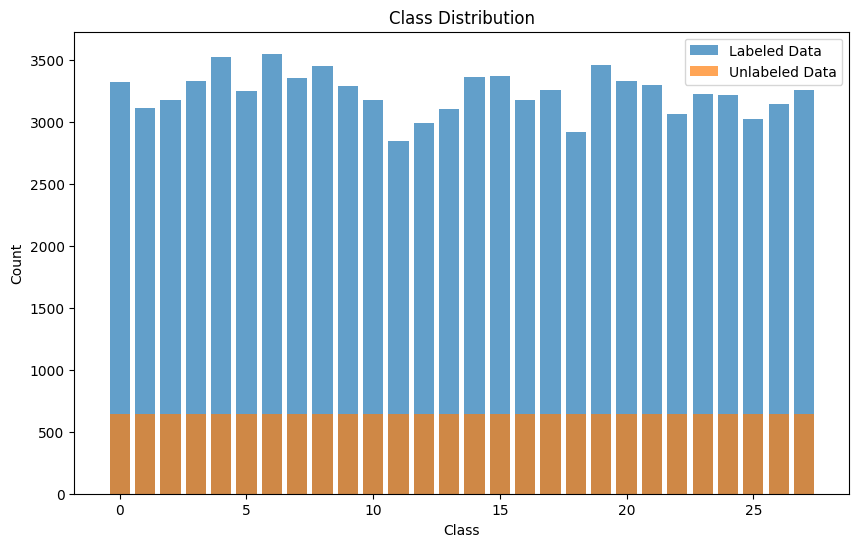

In [37]:
labeled_class_counts = np.bincount(cp.asnumpy(y_labeled))
unlabeled_class_counts = np.bincount(cp.asnumpy(y_unlabeled))

plt.figure(figsize=(10, 6))
plt.bar(cp.asnumpy(cp.arange(len(labeled_class_counts))), cp.asnumpy(labeled_class_counts), alpha=0.7, label='Labeled Data')
plt.bar(cp.asnumpy(cp.arange(len(unlabeled_class_counts))), cp.asnumpy(unlabeled_class_counts), alpha=0.7, label='Unlabeled Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.legend()
plt.show()


Decision Tree Classifer 

In [11]:
classifier = DecisionTreeClassifier(max_depth=12, criterion='entropy', random_state=2411)

confidence_threshold = 0.9
num_iterations = 5

for i in range(num_iterations):
    classifier.fit(X_labeled.get(), y_labeled.get())
    y_pred = cp.asarray(classifier.predict(X_unlabeled.get()))

    # Select high-confidence predictions
    y_pred_prob = cp.asarray(classifier.predict_proba(X_unlabeled.get()))
    max_probs = cp.max(y_pred_prob, axis=1)
    high_confidence_indices = cp.where(max_probs >= confidence_threshold)[0]
    pseudo_labels = y_pred[high_confidence_indices]

    # Add high-confidence examples to the labeled data
    X_labeled = cp.concatenate([X_labeled, X_unlabeled[high_confidence_indices]])
    y_labeled = cp.concatenate([y_labeled, pseudo_labels])

    print(f"Iteration {i + 1}: Labeled Data Size - {X_labeled.shape[0]}, Unlabeled Data Size - {X_unlabeled.shape[0]}")

y_pred = cp.asarray(classifier.predict(X_unlabeled.get()))
accuracy = accuracy_score(y_unlabeled.get(), y_pred.get())
print("Accuracy:", accuracy)


Iteration 1: Labeled Data Size - 21982, Unlabeled Data Size - 17920
Iteration 2: Labeled Data Size - 39117, Unlabeled Data Size - 17920
Iteration 3: Labeled Data Size - 56342, Unlabeled Data Size - 17920
Iteration 4: Labeled Data Size - 73424, Unlabeled Data Size - 17920
Iteration 5: Labeled Data Size - 90601, Unlabeled Data Size - 17920
Accuracy: 0.8901785714285714


Accuracy, Precision, Recall, F1-Score

In [12]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y_unlabeled.get(), y_pred.get(), average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

Precision: 0.8918771928143434
Recall: 0.8901785714285714
F1-score: 0.89039425796032


In [13]:
from sklearn.metrics import classification_report

report = classification_report(y_unlabeled.get(), y_pred.get())
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       640
           1       0.91      0.87      0.89       640
           2       0.92      0.88      0.90       640
           3       0.95      0.95      0.95       640
           4       0.87      0.93      0.90       640
           5       0.93      0.90      0.92       640
           6       0.87      0.96      0.92       640
           7       0.89      0.88      0.89       640
           8       0.85      0.89      0.87       640
           9       0.91      0.91      0.91       640
          10       0.94      0.94      0.94       640
          11       0.90      0.83      0.87       640
          12       0.92      0.81      0.86       640
          13       0.89      0.85      0.87       640
          14       1.00      1.00      1.00       640
          15       0.85      0.88      0.86       640
          16       0.95      0.92      0.94       640
    

Learning Curve  

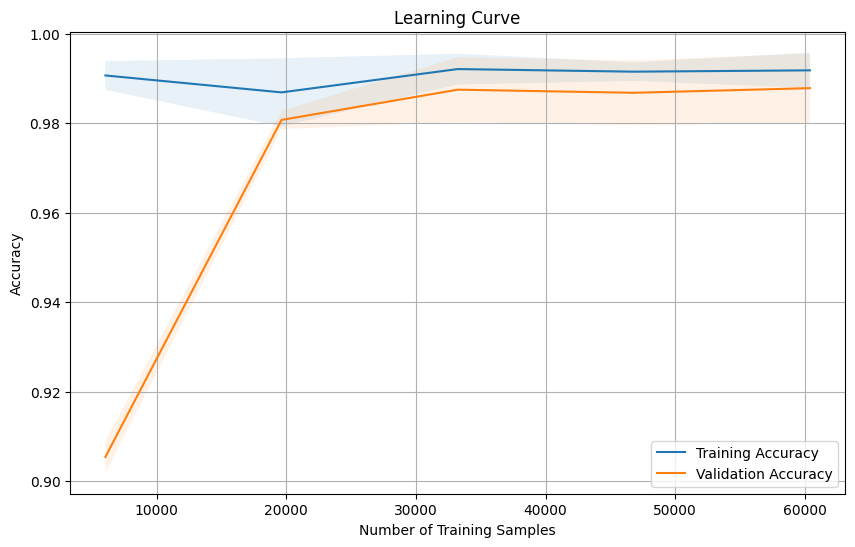

In [14]:
from sklearn.model_selection import learning_curve


# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(classifier, X_labeled.get(), y_labeled.get(), cv=3, scoring='accuracy')
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, val_mean, label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
import numpy as np

# Assuming your dataset is stored in the variable 'y_unlabeled'
classes = np.unique(y_unlabeled.get())

print(classes)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


ROC CURVE GRAPH

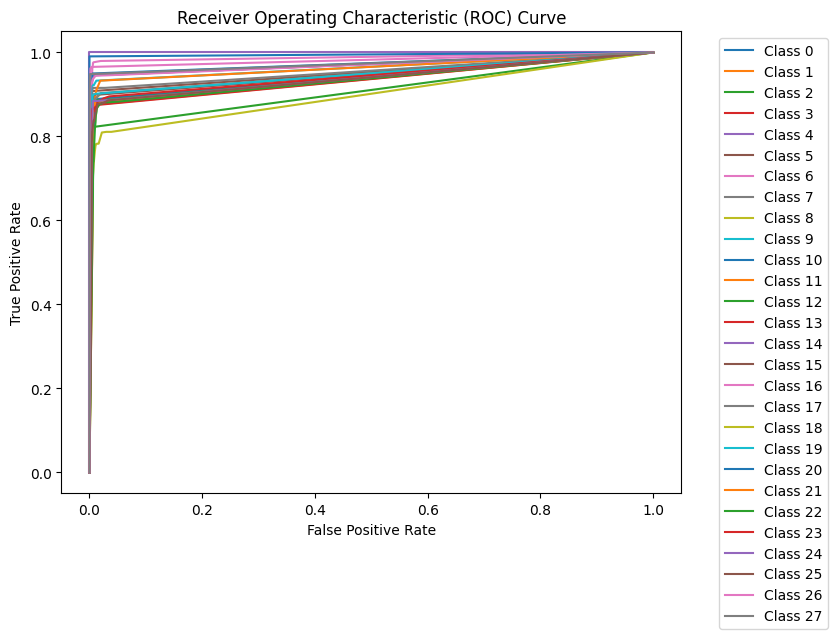

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

y_scores = classifier.predict_proba(cp.asnumpy(X_unlabeled.get()))

fprs = []
tprs = []
thresholds = []
for i in range(len(classes)):
    y_binary = (cp.asnumpy(y_unlabeled.get() == classes[i])).astype(int)
    fpr, tpr, threshold = roc_curve(y_binary, y_scores[:, i])
    fprs.append(fpr)
    tprs.append(tpr)
    thresholds.append(threshold)

plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.plot(fprs[i], tprs[i], label=f'Class {classes[i]}')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Hyper-parameter with GridSearch

In [42]:
import cupy as cp
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

X_labeled = cp.asnumpy(X_labeled)
y_labeled = cp.asnumpy(y_labeled)

param_grid = {
    'max_depth':list(range(1, 32)),
    'criterion': ['gini', 'entropy'],
}

classifier = DecisionTreeClassifier(random_state=2411)

grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=8)
grid_search.fit(X_labeled, y_labeled)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Accuracy plots for different Hyperparameters

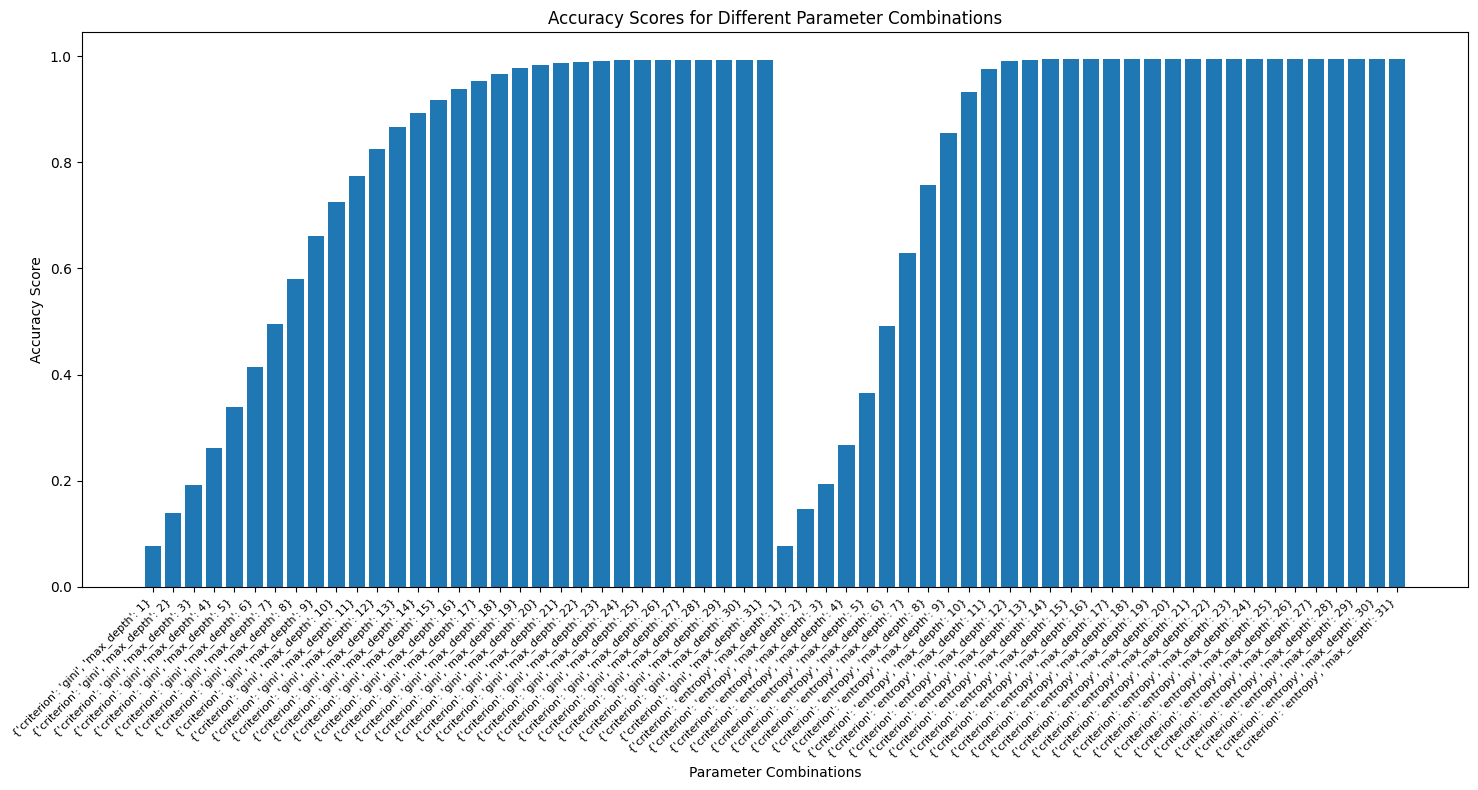

In [18]:
results = grid_search.cv_results_
param_combinations = results['params']
mean_scores = results['mean_test_score']

plt.figure(figsize=(15, 8))
plt.bar(range(len(mean_scores)), mean_scores)
plt.xlabel('Parameter Combinations')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Different Parameter Combinations')
plt.xticks(range(len(mean_scores)), [str(param) for param in param_combinations], rotation=45, ha='right', fontsize=8)
plt.gca().set_xticklabels([str(param) for param in param_combinations], rotation=45, ha='right')
plt.tight_layout()
plt.show()

Confusion Matrix

In [19]:
from sklearn.metrics import confusion_matrix

y_unlabeled_np = cp.asnumpy(y_unlabeled)
y_pred_np = cp.asnumpy(y_pred)

# Compute confusion matrix
confusion_mat = confusion_matrix(y_unlabeled_np, y_pred_np)
# print("Confusion Matrix:")
# print(confusion_mat)

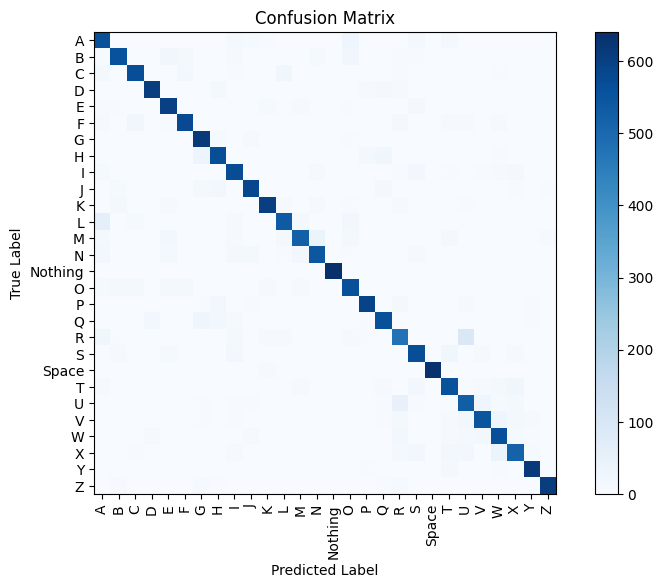

In [40]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_encoder.classes_))
plt.xticks(tick_marks, label_encoder.classes_, rotation=90)
plt.yticks(tick_marks, label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

T-Sne Plot for both labeled and unlabeled data

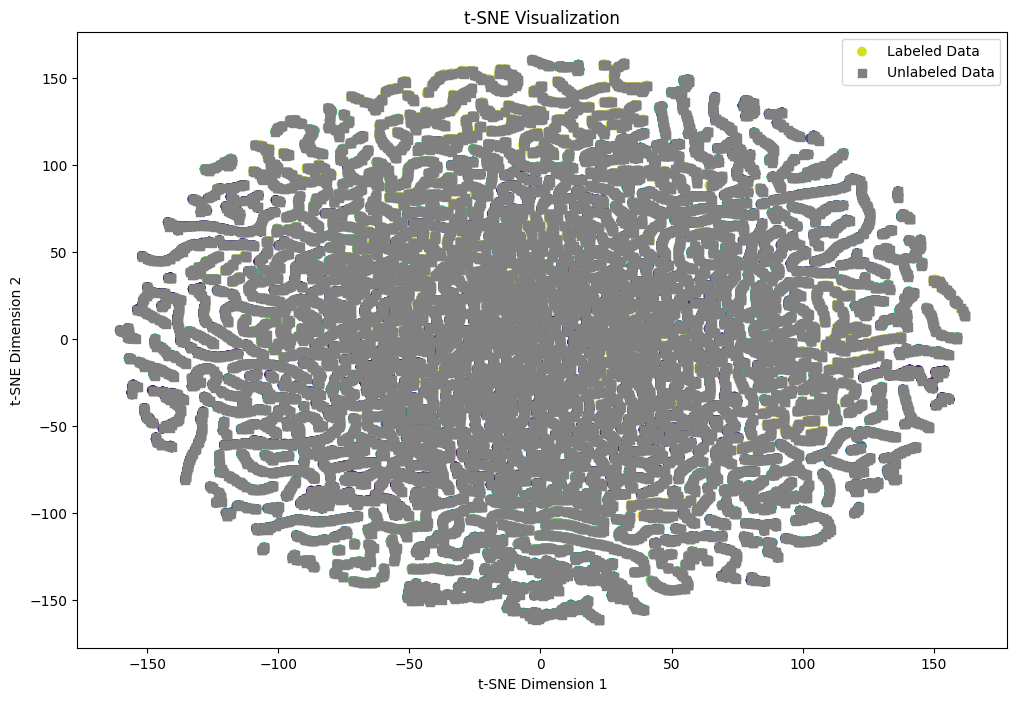

In [30]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=2411, perplexity=30, n_iter=1000)
X_combined = np.concatenate((cp.asnumpy(X_labeled), cp.asnumpy(X_unlabeled)), axis=0)
X_tsne = tsne.fit_transform(X_combined)

# Separate labeled and unlabeled data in t-SNE space
X_tsne_labeled = X_tsne[:X_labeled.shape[0]]
X_tsne_unlabeled = X_tsne[X_labeled.shape[0]:]

# Plot the t-SNE visualization
plt.figure(figsize=(12, 8))
plt.scatter(X_tsne_labeled[:, 0], X_tsne_labeled[:, 1], c=y_labeled, cmap='viridis', label='Labeled Data')
plt.scatter(X_tsne_unlabeled[:, 0], X_tsne_unlabeled[:, 1], c='gray', label='Unlabeled Data', marker='s')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization')
plt.legend()
plt.show()



Outliner Detection

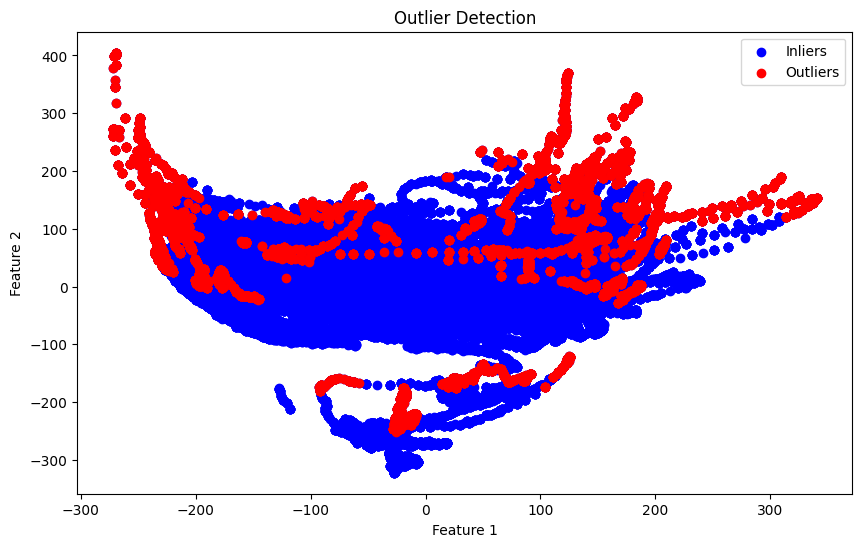

In [34]:
from sklearn.ensemble import IsolationForest

X_combined = np.concatenate((cp.asnumpy(X_labeled), cp.asnumpy(X_unlabeled)), axis=0)

outlier_detector = IsolationForest(random_state=2411)
outlier_labels = cp.asnumpy(outlier_detector.fit_predict(X_combined))

outliers = X_combined[outlier_labels == -1]

plt.figure(figsize=(10, 6))
plt.scatter(cp.asnumpy(X_combined[:, 0]), cp.asnumpy(X_combined[:, 1]), c='blue', label='Inliers')
plt.scatter(cp.asnumpy(outliers[:, 0]), cp.asnumpy(outliers[:, 1]), c='red', label='Outliers')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Outlier Detection')
plt.legend()
plt.show()

Feature Correlation Matrix

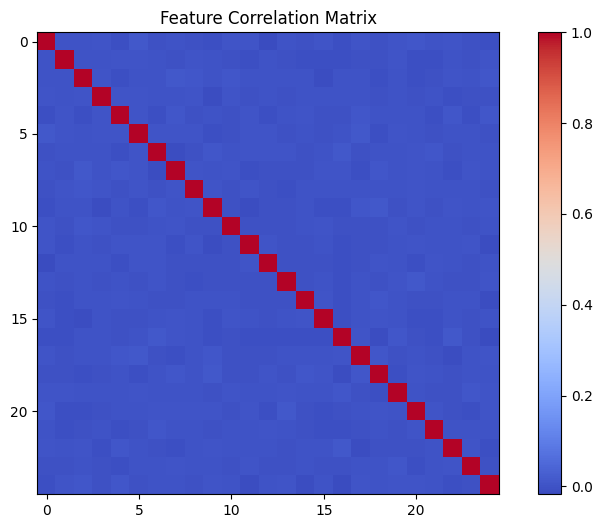

In [38]:
X_combined = np.concatenate((cp.asnumpy(X_labeled), cp.asnumpy (X_unlabeled)), axis=0)
correlation_matrix = cp.corrcoef(X_combined.T)

plt.figure(figsize=(10, 6))
plt.imshow(cp.asnumpy(correlation_matrix), cmap='coolwarm', origin='upper')
plt.colorbar()
plt.title('Feature Correlation Matrix')
plt.show()
